In [1]:
%matplotlib inline

In [2]:
from collections import defaultdict

In [3]:
from kid_readout.measurement.io import npy
from kid_readout.measurement import plot_basic
from kid_readout.analysis.resonator import lmfit_resonator

In [4]:
plot_directory = '/home/flanigan/temp/'

In [5]:
npd = npy.NumpyDirectory('/data/detectors/2017-03-08_151445_scan.npd/')

In [6]:
sweeps = [npd.read(name) for name in npd.node_names() if name.startswith('SweepArray')]

In [7]:
snaps = [npd.read(name) for name in npd.node_names() if name.startswith('ADCSnap')]

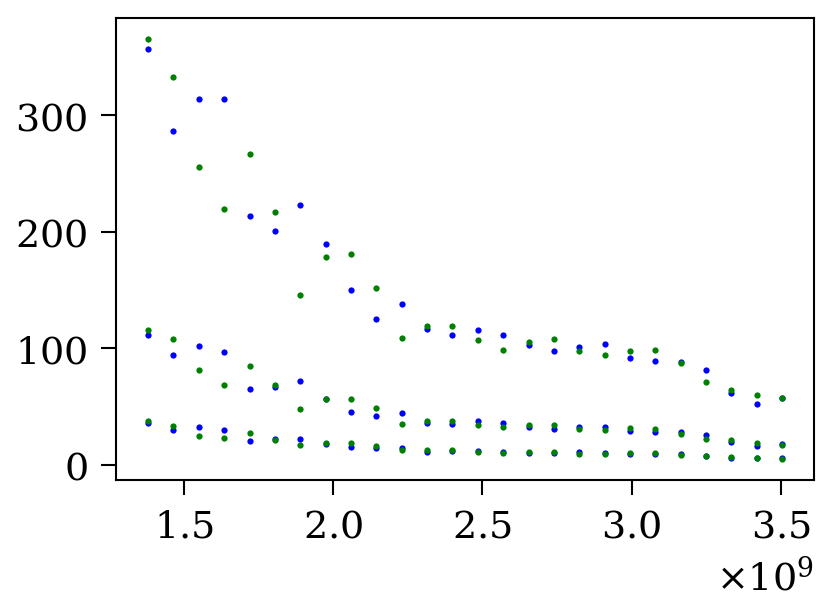

In [8]:
fig, ax = plt.subplots()
for sweep, snap in zip(sweeps, snaps):
    ax.plot(sweep.frequency.mean(), snap.x.std(), '.b')
    ax.plot(sweep.frequency.mean(), snap.y.std(), '.g')

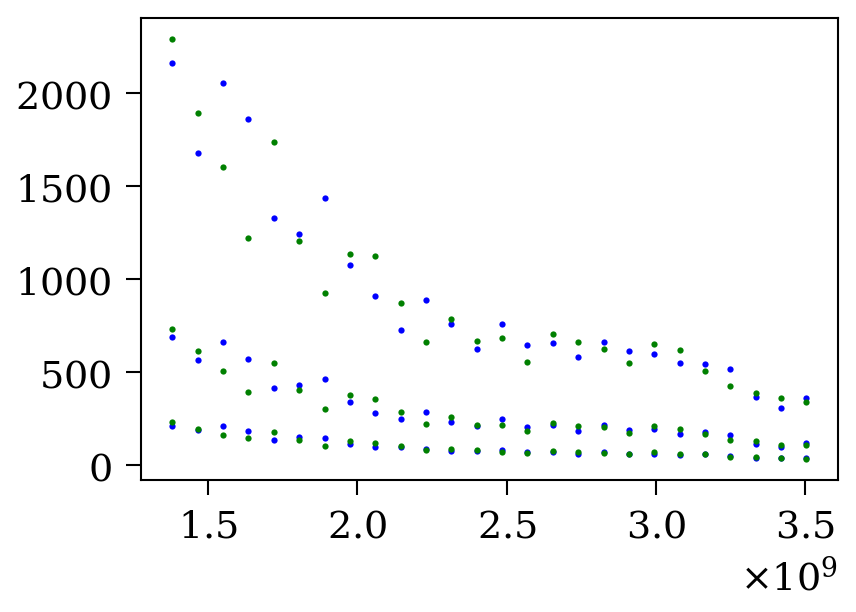

In [9]:
fig, ax = plt.subplots()
for sweep, snap in zip(sweeps, snaps):
    ax.plot(sweep.frequency.mean(), snap.x.ptp(), '.b')
    ax.plot(sweep.frequency.mean(), snap.y.ptp(), '.g')

# Organize data

In [10]:
sweep_dict = defaultdict(list)
for sweep in sweeps:
    sweep_dict[sweep.stream_arrays[0].roach_state.dac_attenuation].append(sweep)

# Nominal resonances

In [11]:
f_nominal = 1e9 * np.array([1.97, 2.38, 2.78, 3.19])

# Remove background

In [12]:
def remove_background(f, s21, amp_degree=4, phi_degree=4, weights=None):
    if weights is None:
        weights = np.abs(s21)**2
    amp_poly = np.polyfit(f, np.abs(s21), deg=amp_degree, w=weights)
    phi_poly = np.polyfit(f, np.unwrap(np.angle(s21)), deg=phi_degree, w=weights)
    return s21 / (np.polyval(amp_poly, f) * np.exp(1j * np.polyval(phi_poly, f)))

# Stitch sweeps

In [13]:
attenuation = 10
sweeps = sweep_dict[attenuation]
n = sweeps[0].frequency.size
overlap = int(n / 2)
left_weight = np.linspace(1, 0, overlap)
right_weight = np.linspace(0, 1, overlap)
frequencies = [sweeps[0].frequency[:overlap]]
amplitudes = [np.abs(sweeps[0].s21_point[:overlap])]
for left, right in zip(sweeps[:-1], sweeps[1:]):
    frequencies.append(left.frequency[overlap:])
    amplitudes.append(left_weight * np.abs(left.s21_point[overlap:]) +
                      right_weight * np.abs(right.s21_point[:overlap]))
frequencies.append(sweeps[-1].frequency[overlap:])
amplitudes.append(np.abs(sweeps[-1].s21_point[overlap:]))
frequency = np.concatenate(frequencies)
amplitude = np.concatenate(amplitudes)
width = int(n / 10)
kernel = np.exp(-np.linspace(-4, 4, width) ** 2)
kernel /= kernel.sum()
smoothed = np.convolve(kernel, amplitude, mode='same')
smoothed[:width] = smoothed[width + 1]
smoothed[-width:] = smoothed[-(width + 1)]

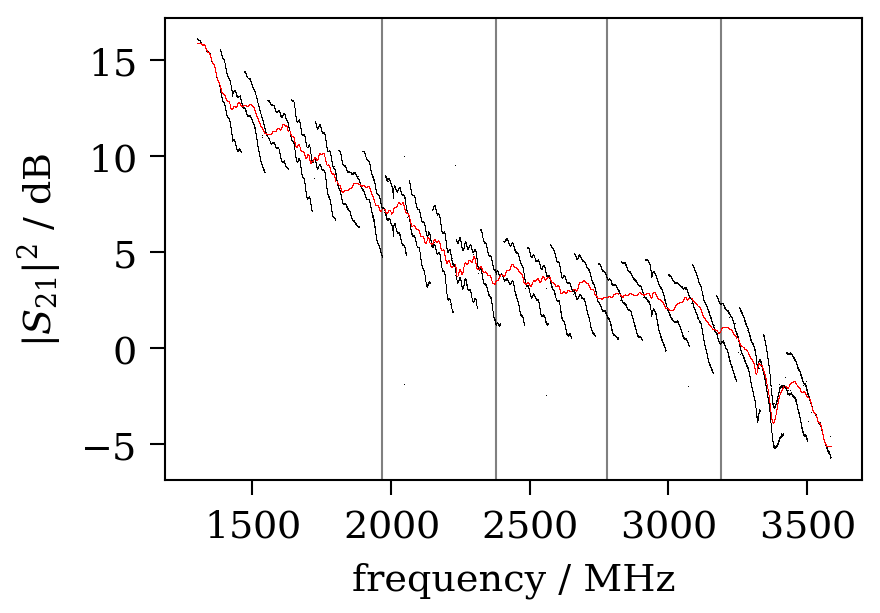

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('$|S_{21}|^2$ / dB')

for f in f_nominal:
    ax.axvline(1e-6 * f, color='gray')
for sweep in sweeps:
    ax.plot(sweep.frequency_MHz, 20 * np.log10(np.abs(sweep.s21_point)), ',k')
ax.plot(1e-6 * frequency, 20 * np.log10(np.abs(smoothed)), ',r')

In [15]:
abs_poly = np.polyfit(frequency, np.abs(smoothed), deg=5)

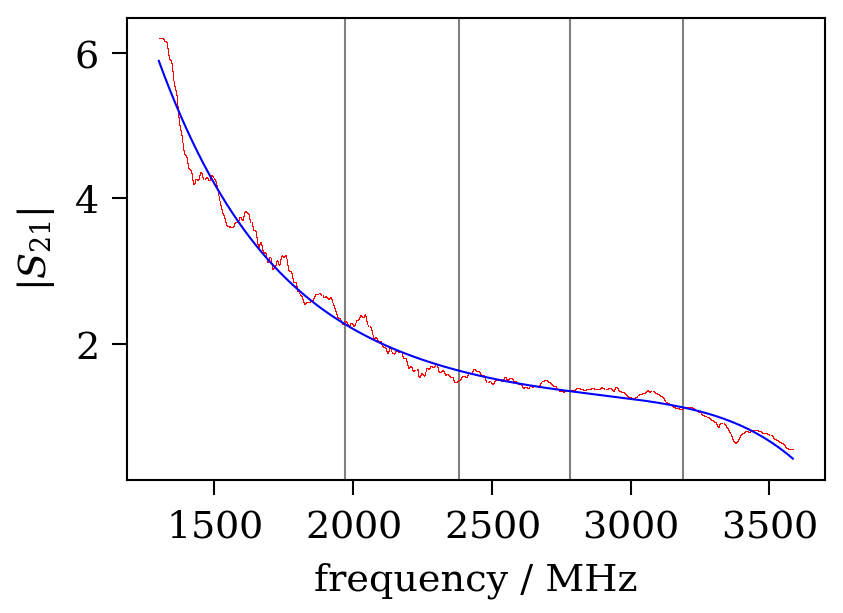

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('$|S_{21}|$')
for f in f_nominal:
    ax.axvline(1e-6 * f, color='gray')
ax.plot(1e-6 * frequency, np.abs(smoothed), ',r')
ax.plot(1e-6 * frequency, np.polyval(abs_poly, frequency), '-b')

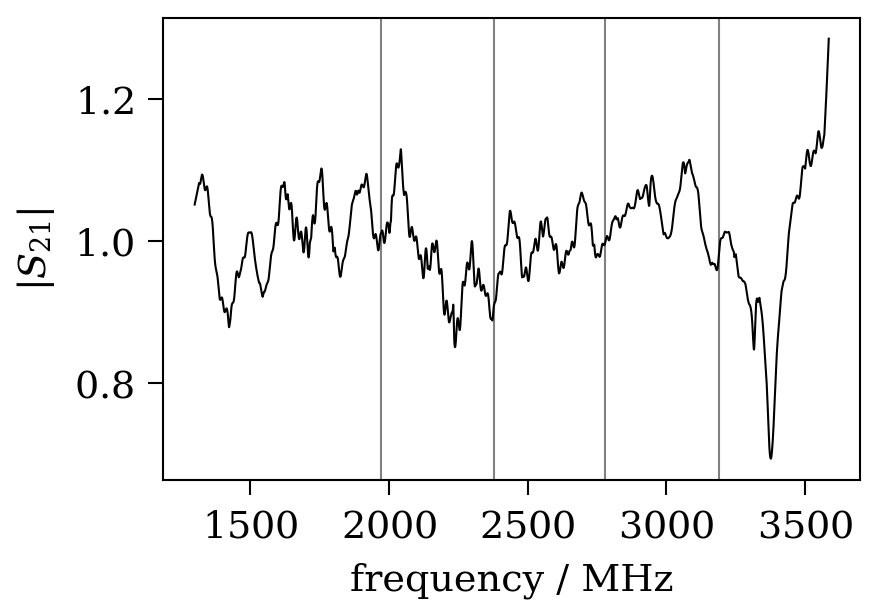

In [17]:
fig, ax = plt.subplots()
ax.set_xlabel('frequency / MHz')
ax.set_ylabel('$|S_{21}|$')
for f in f_nominal:
    ax.axvline(1e-6 * f, color='gray')
ax.plot(1e-6 * frequency, np.abs(smoothed) / np.polyval(abs_poly, frequency), '-k')

# Raw data

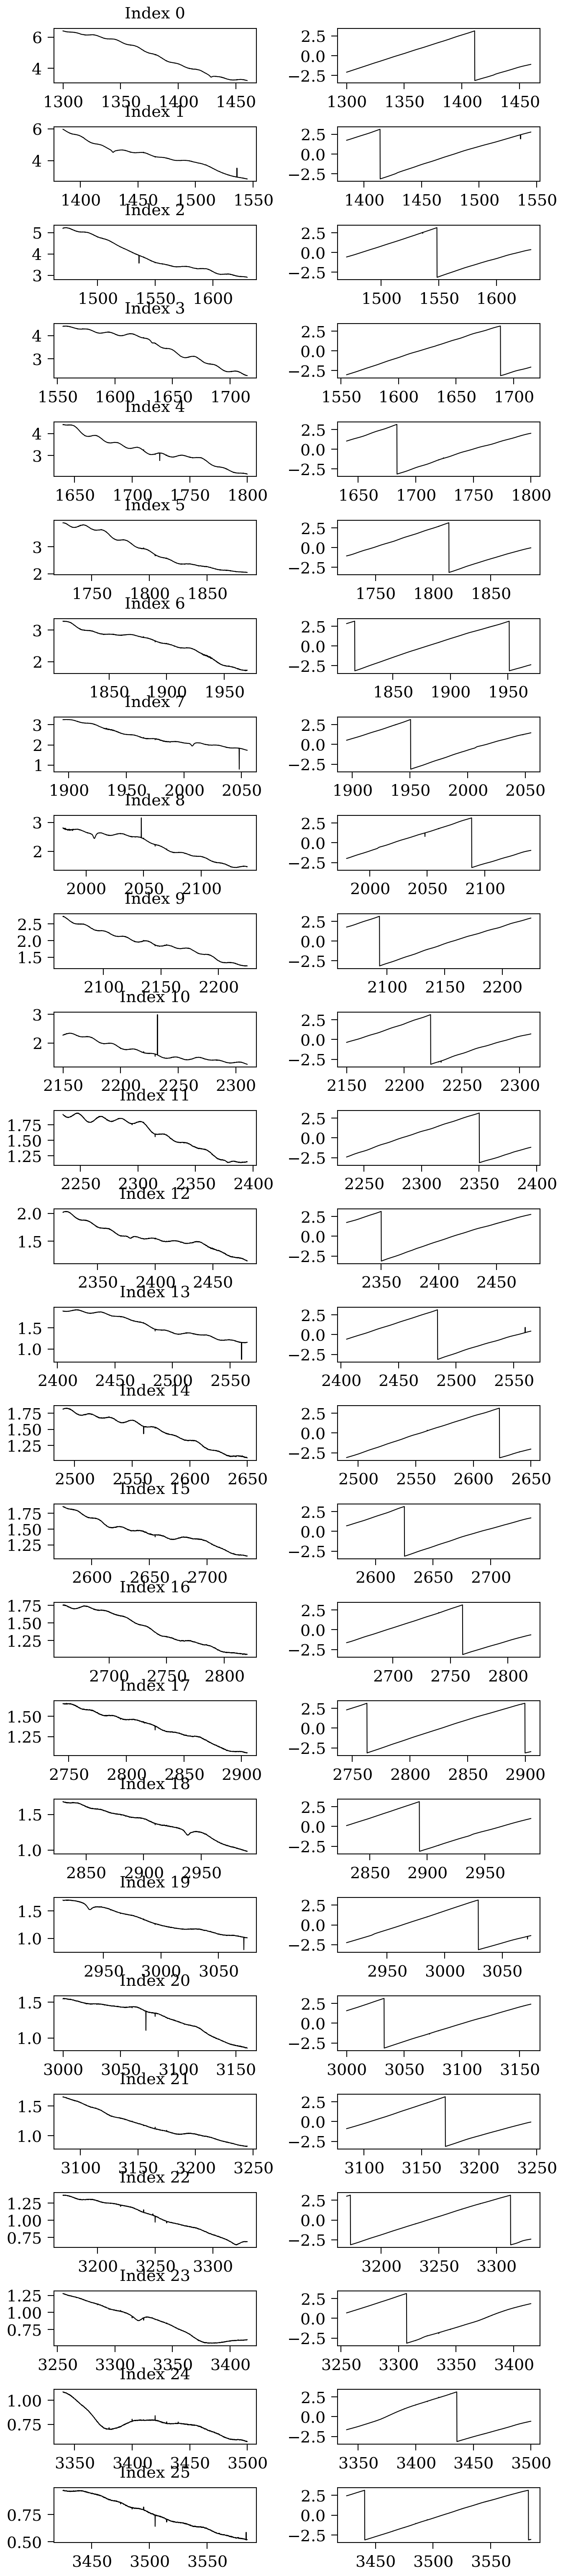

In [18]:
num_sweeps = len(sweeps)
fig, axes = plt.subplots(num_sweeps, 2, figsize=(5, num_sweeps), gridspec_kw={'wspace': 0.4, 'hspace': 0.8})
for index, (sweep, (amp_ax, phi_ax)) in enumerate(zip(sweeps, np.atleast_2d(axes))):
    amp_ax.set_title('Index {:d}'.format(index))
    s21 = sweep.s21_point
    amp_ax.plot(sweep.frequency_MHz, np.abs(s21), '-k')
    phi_ax.plot(sweep.frequency_MHz, np.angle(s21), '-k')

# Remove background

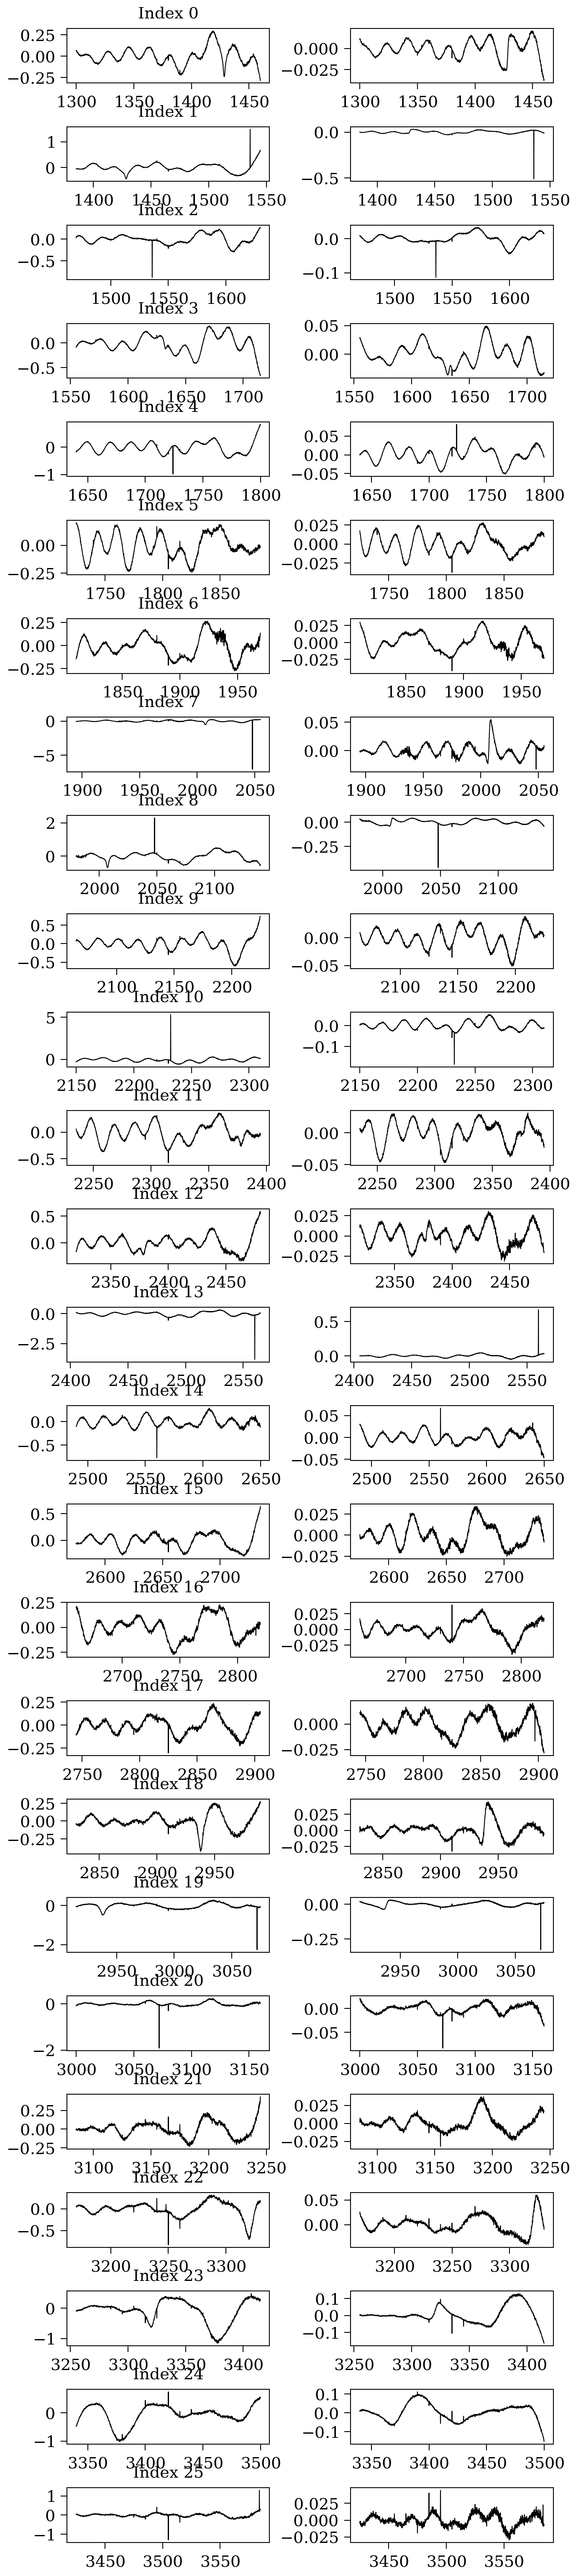

In [19]:
num_sweeps = len(sweeps)
fig, axes = plt.subplots(num_sweeps, 2, figsize=(5, num_sweeps), gridspec_kw={'wspace': 0.4, 'hspace': 0.8})
for index, (sweep, (amp_ax, phi_ax)) in enumerate(zip(sweeps, np.atleast_2d(axes))):
    amp_ax.set_title('Index {:d}'.format(index))
    s21 = remove_background(sweep.frequency, sweep.s21_point)
    amp_ax.plot(sweep.frequency_MHz, 20 * np.log10(np.abs(s21)), '-k')
    phi_ax.plot(sweep.frequency_MHz, np.angle(s21), '-k')

In [20]:
candidates = [1, 3, 7, 12, 18, 23]

In [21]:
def fit_and_plot(sweep, ax, min_snr=0.5, Q=30000, num_linewidths=10, threshold=1):
    peaks = sweep.find_resonances(min_snr=min_snr, threshold=threshold)
    rs = [sweep.resonator(frequency=sweep.frequency[peak], width=num_linewidths * sweep.frequency.mean() / Q,
                       model=lmfit_resonator.LinearLossResonatorWithCable)
          for peak in peaks]
    rs = [r for r in rs if 
          1e-6 < r.loss_c and r.loss_c < 1e-2 and
          1e-6 < r.loss_i and r.loss_i < 1e-2
         ]
    for f in f_nominal:
        if sweep.frequency.min() < f and f < sweep.frequency.max():
            ax.axvline(1e-6 * f, color='green')
    ax.plot(sweep.frequency_MHz, np.abs(sweep.s21_point_foreground), color='gray')
    #ax.plot(sweep.frequency_MHz[peaks], np.abs(sweep.s21_point_foreground[peaks]), '.', color='green')
    for r in rs:
        plot_basic.resonator_amplitude(r, ax, normalize=False, decibels=False, three_ticks=False)
    return rs

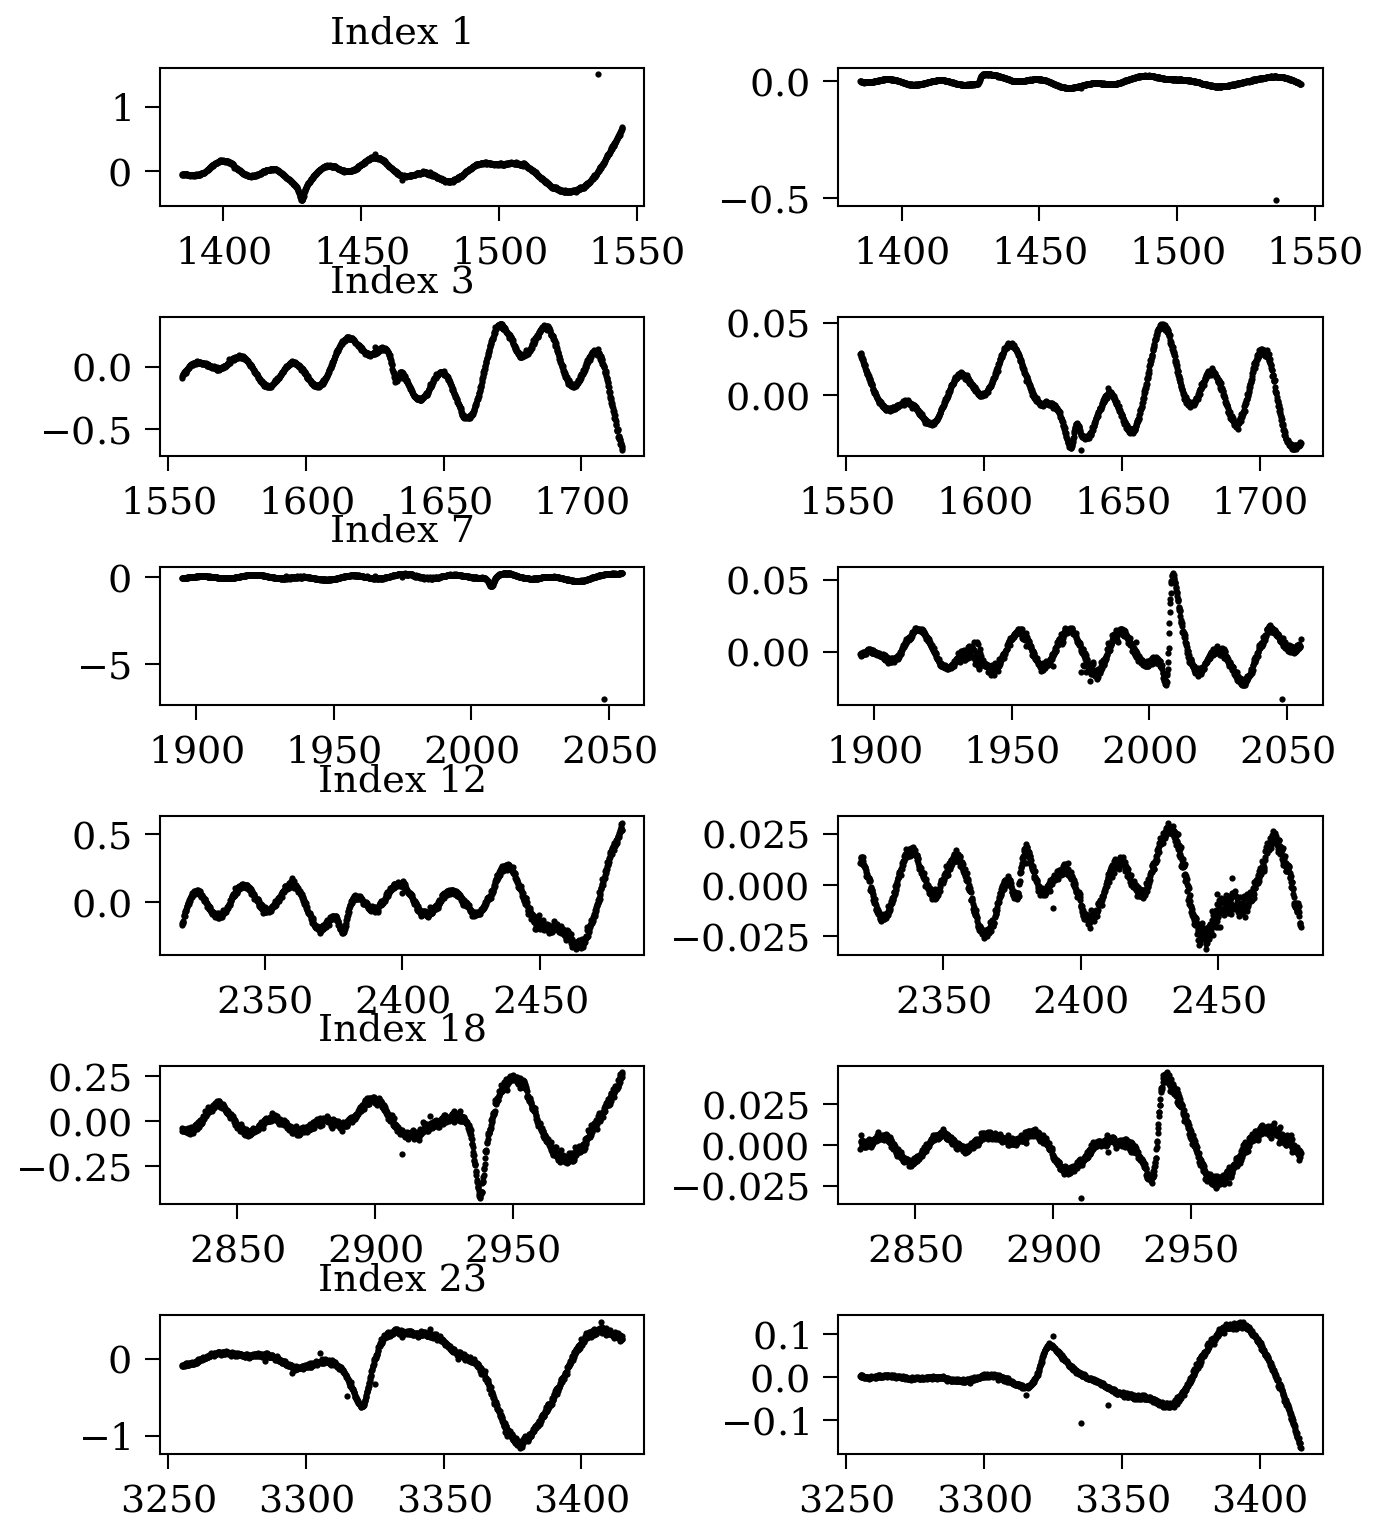

In [22]:
num_sweeps = len(candidates)
fig, axes = plt.subplots(num_sweeps, 2, figsize=(5, num_sweeps), gridspec_kw={'wspace': 0.4, 'hspace': 0.8})
for index, (amp_ax, phi_ax) in zip(candidates, np.atleast_2d(axes)):
    sweep = sweeps[index]
    for f in f_nominal:
        if sweep.frequency.min() < f and f < sweep.frequency.max():
            ax.axvline(1e-6 * f, color='red')
    amp_ax.set_title('Index {:d}'.format(index))
    f_min = sweep.frequency[np.argmin(np.abs(sweep.s21_point))]
    phi_ax.set_title('')
    s21 = remove_background(sweep.frequency, sweep.s21_point)
    amp_ax.plot(sweep.frequency_MHz, 20 * np.log10(np.abs(s21)), '.k')
    phi_ax.plot(sweep.frequency_MHz, np.angle(s21), '.k')

/home/flanigan/readout/kid_readout/kid_readout/analysis/resonator/equations.py:86: RuntimeWarning: divide by zero encountered in true_divide
  (1 + (loss_i + 2j * x) / loss_c))
/home/flanigan/readout/kid_readout/kid_readout/analysis/resonator/equations.py:86: RuntimeWarning: invalid value encountered in true_divide
  (1 + (loss_i + 2j * x) / loss_c))


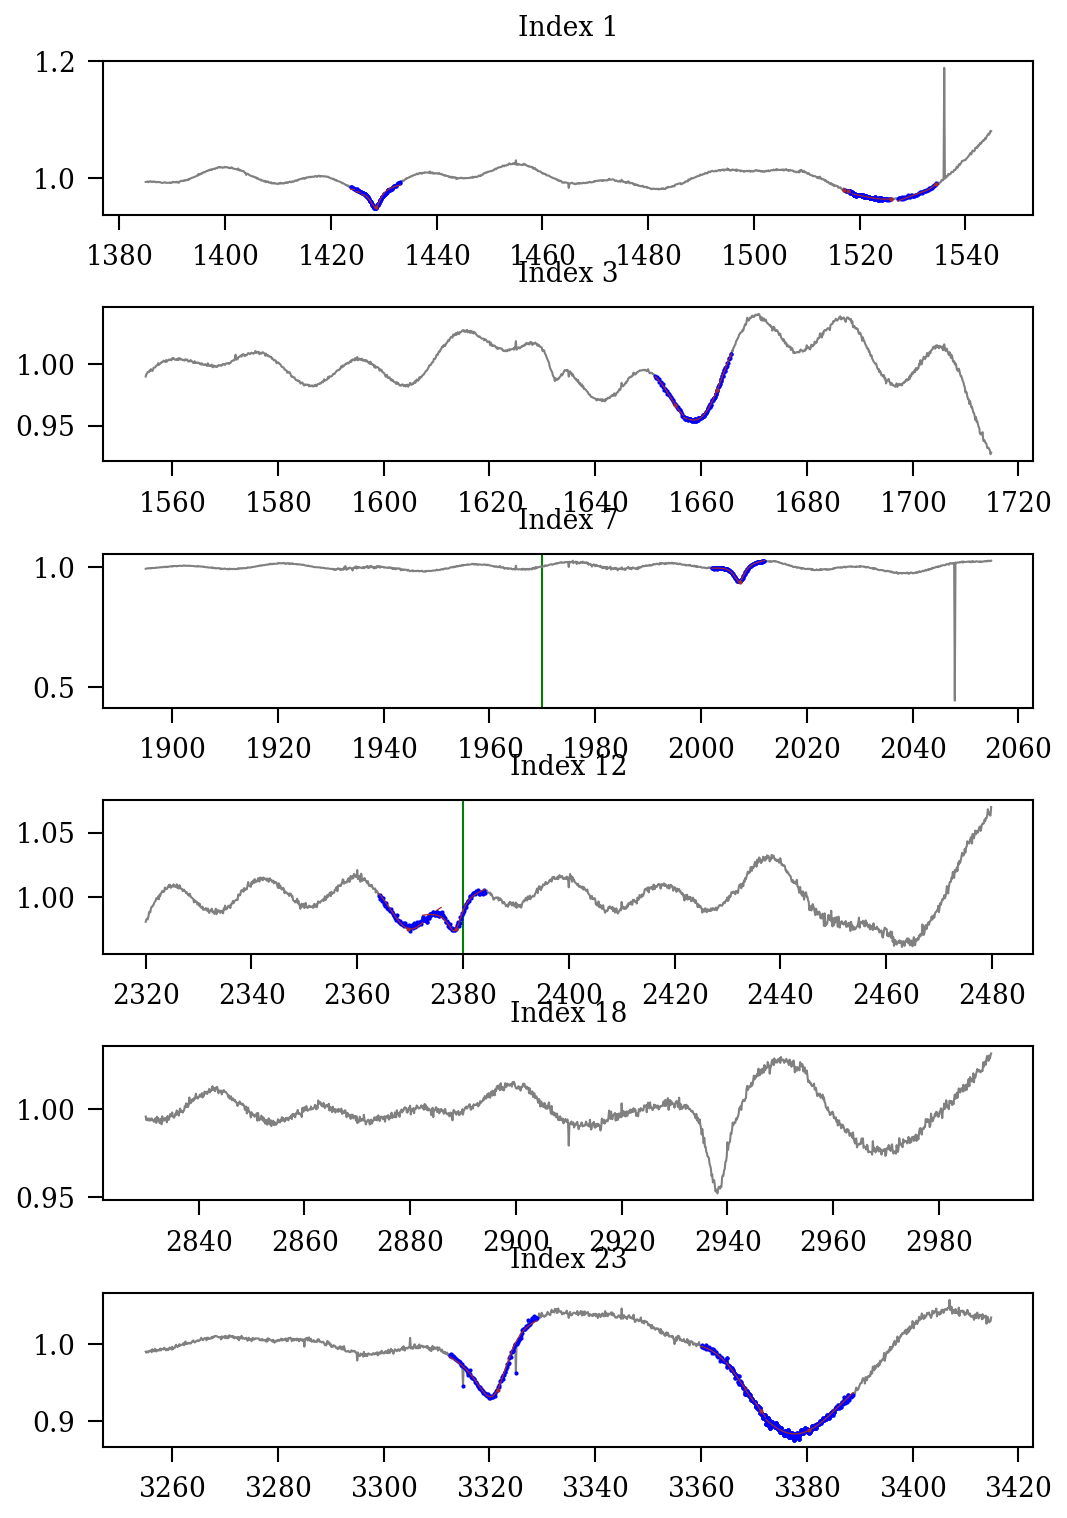

In [23]:
resonators = []
num_subplots = len(candidates)
fig, axes = plt.subplots(num_subplots, 1, figsize=(4, num_subplots), gridspec_kw={'hspace': 0.6})
for index, ax in zip(candidates, np.atleast_1d(axes).flatten()):
    sweep = sweeps[index]
    ax.tick_params(labelsize='xx-small')
    ax.set_title("Index {}".format(index), fontsize='xx-small')
    resonators.extend(fit_and_plot(sweep, ax, Q=3000, num_linewidths=15, min_snr=0.1, threshold=1.5))